# Credit Card Fraud Data Analysis

This Project goes through the 2013 Credit Fraud Dataset on Kaggle. This is real data that is omits anything personal that can identify people while also annoymizing variable names. This only contains numericals values as data. Time is based off since the system is started to when the transaction is taken place and the ammount is the $ spent for the transaction. This is not standardized. 

I will be analyzing this data and building a model that can hopefully work on the limited data that was provided and give a reasonable precision/recall. Accuracy is not looked at much since this is imbalanced data.

## Preprocessing Data

This goes through importing libraries, and getting a overall understanding of the data before I transform or add features

### Importing Libraries

In [55]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, accuracy_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import warnings

In [52]:
warnings.filterwarnings("ignore", category=UserWarning)

### Loading Data

In [8]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Expolaratory Data Analysis(EDA)

#### Row Count

In [7]:
num_rows, num_columns = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 284807
Number of columns: 31


#### Checking for Missing Values

In [8]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

#### Vizualizing Class Distribution

In [9]:
class_distribution = df['Class'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


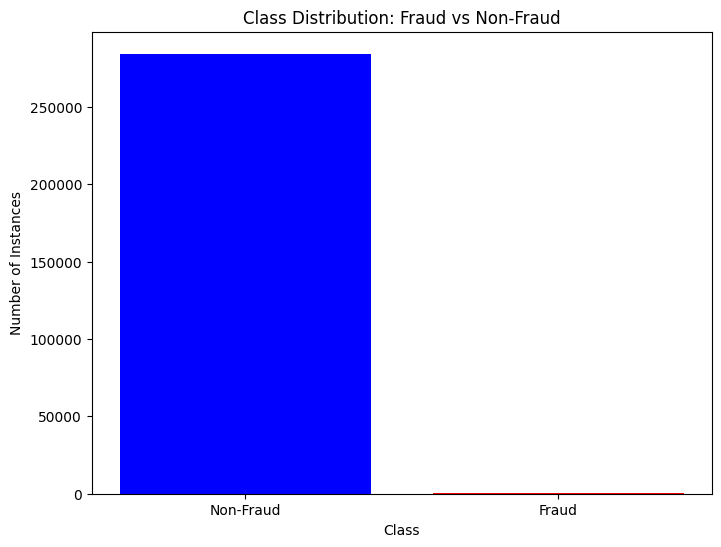

In [10]:
plt.figure(figsize=(8, 6))
plt.bar(class_distribution.index, class_distribution.values, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xticks(ticks=class_distribution.index, labels=['Non-Fraud', 'Fraud'])
plt.show()

#### Distribution of Amounts

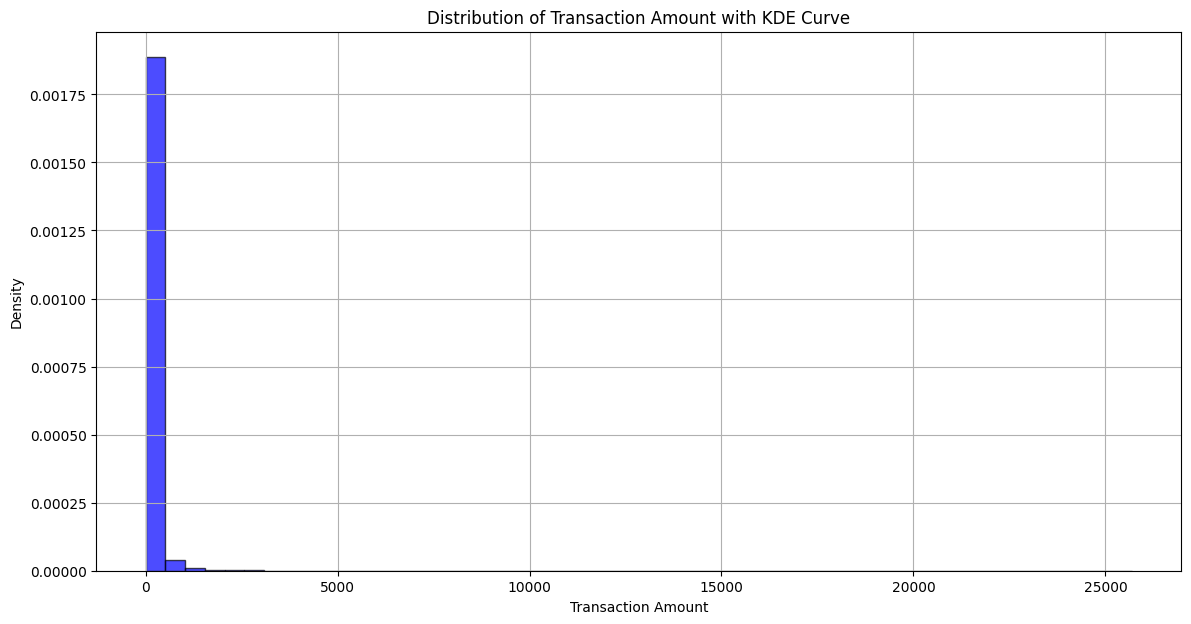

In [11]:
plt.figure(figsize=(14, 7))


n, bins, patches = plt.hist(df['Amount'], bins=50, color='blue', alpha=0.7, density=True, edgecolor='black')

plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Distribution of Transaction Amount with KDE Curve')
plt.grid(True)
plt.show()

#### Correlating features

In [12]:
corr_matrix = df.corr()

<Figure size 1200x1000 with 0 Axes>

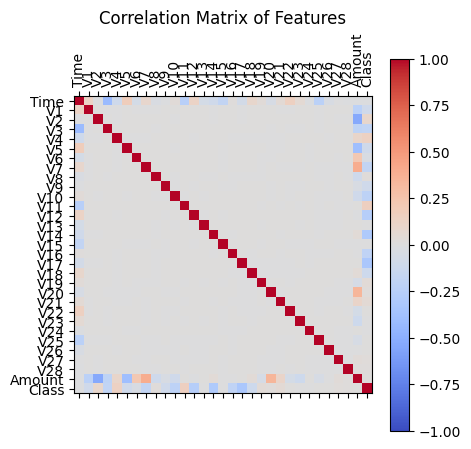

In [13]:
plt.figure(figsize=(12, 10))
cax = plt.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cax)
plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns)
plt.title('Correlation Matrix of Features')
plt.show()

In [14]:
corr_target = corr_matrix['Class'].sort_values(ascending=False)

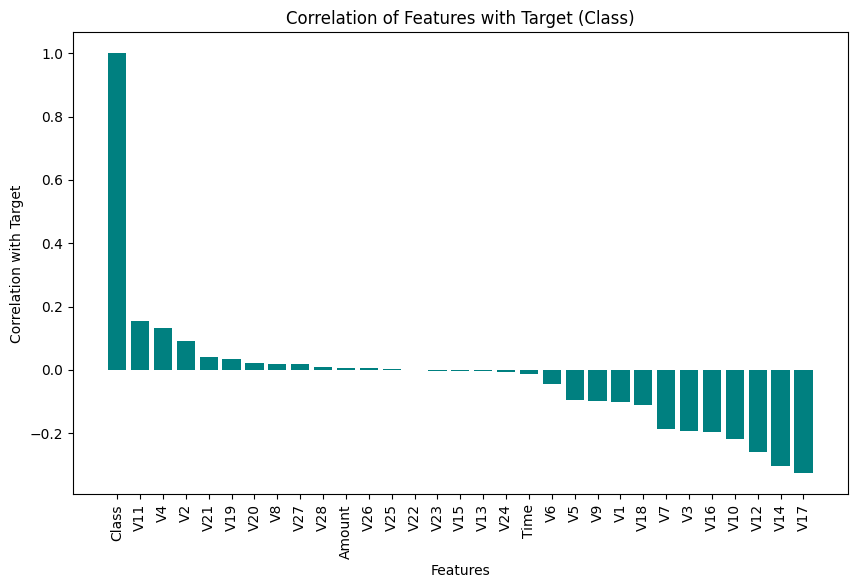

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(corr_target.index, corr_target.values, color='teal')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Correlation of Features with Target (Class)')
plt.xticks(rotation=90)
plt.show()

We can see that there is a high class imbalance and also that there isnt much of a high correlation between class and other variables. This might not be the case when looking at variables together when building that model, but currently single variables don't link to fraud.

#### Checking Fraud Dataframe

In [16]:
fraud_df = df[df['Class'] == 1]

In [17]:
fraud_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,...,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,...,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,...,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


### Feature Selection/Engineering

I will be going through changes made to variables and things that are added. I will standardize the Amounts variable but i will apply to other variables just to make sure its the same standardization. The Time also might indrectly cause problems when predicting as the model might overfit and just target certain time values since there is a imbalance. I will use Time since Last fraud from last transaction instead. This should help somewhat when predicting which is fraud if fraud cases are linked to one another. Since the data will be split, the time won't correlate across sets.

#### Time Since Last Fraud

We have to be careful here because the same time can have multiple tranactions and apply the same time difference. This makes sure it doesn't just learn the times and overfits to it. The thing is because its real time, lagged time will pretty much be 1. To get a better result, I made a time since last fraud which will serve as a helper, and time will be dropped completely. To prevent data leakage, the first farud will have 0 and the timer will only increment once a fraud occurs and resets on the transaction after the fraud.

In [9]:
df['Time_Since_Last_Fraud'] = 0

last_fraud_time = -1

for i in range(len(df)):
    
    if last_fraud_time == -1:
        df.loc[i, 'Time_Since_Last_Fraud'] = 0
    else:
        df.loc[i, 'Time_Since_Last_Fraud'] = df.loc[i, 'Time'] - last_fraud_time

    if df.loc[i, 'Class'] == 1:
        last_fraud_time = df.loc[i, 'Time'] # Changed after fraud to prevent data leakage from setting all fraud cases to 0. set to 0 after fraud

Vizualizing to see if fraud transactions take place near each other.

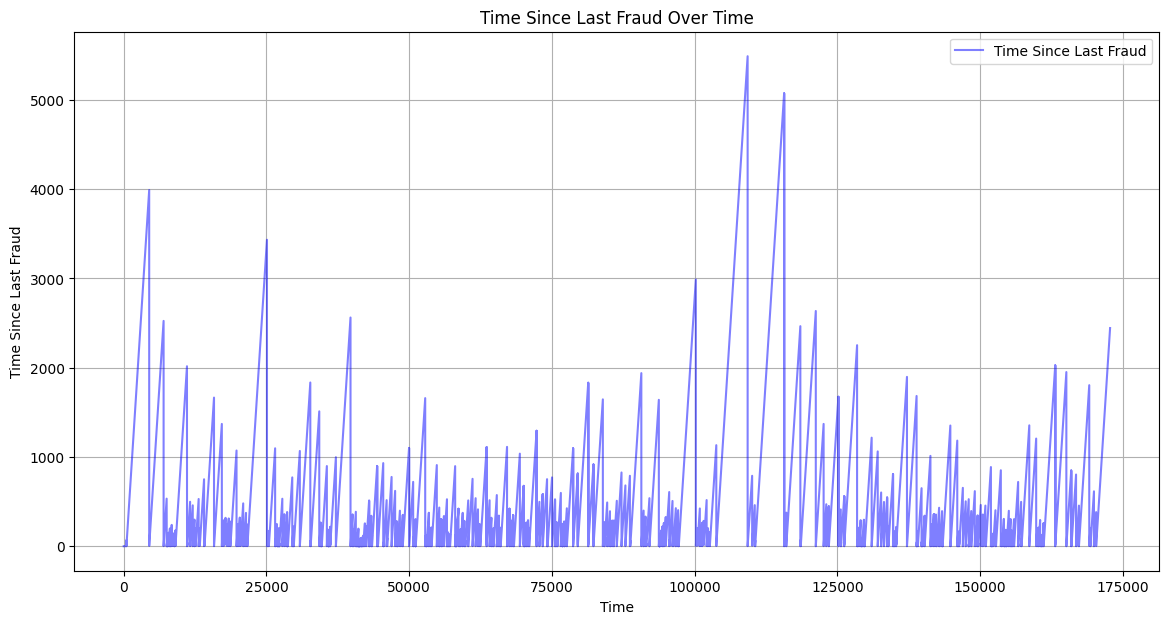

In [19]:
import matplotlib.pyplot as plt

# Ensure data is sorted by Time
df_sorted = df.sort_values(by='Time').reset_index(drop=True)

# Create a line plot for Time_Since_Last_Fraud
plt.figure(figsize=(14, 7))
plt.plot(df_sorted['Time'], df_sorted['Time_Since_Last_Fraud'], label='Time Since Last Fraud', color='blue', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Time Since Last Fraud')
plt.title('Time Since Last Fraud Over Time')
plt.legend()
plt.grid(True)
plt.show()

We can see that frauds usually are close in time compared to one another until they stop and a new fraud transaction takes place.

#### Transaction in Same Time

This is just to identify which transaction came first. if the Time if same then the once that is first in the row for that time is 1, and then 2 etc.

In [10]:
df['Transaction_Order'] = df.groupby('Time').cumcount() + 1

In [11]:
time_order_counts = df.groupby('Time')['Transaction_Order'].count()

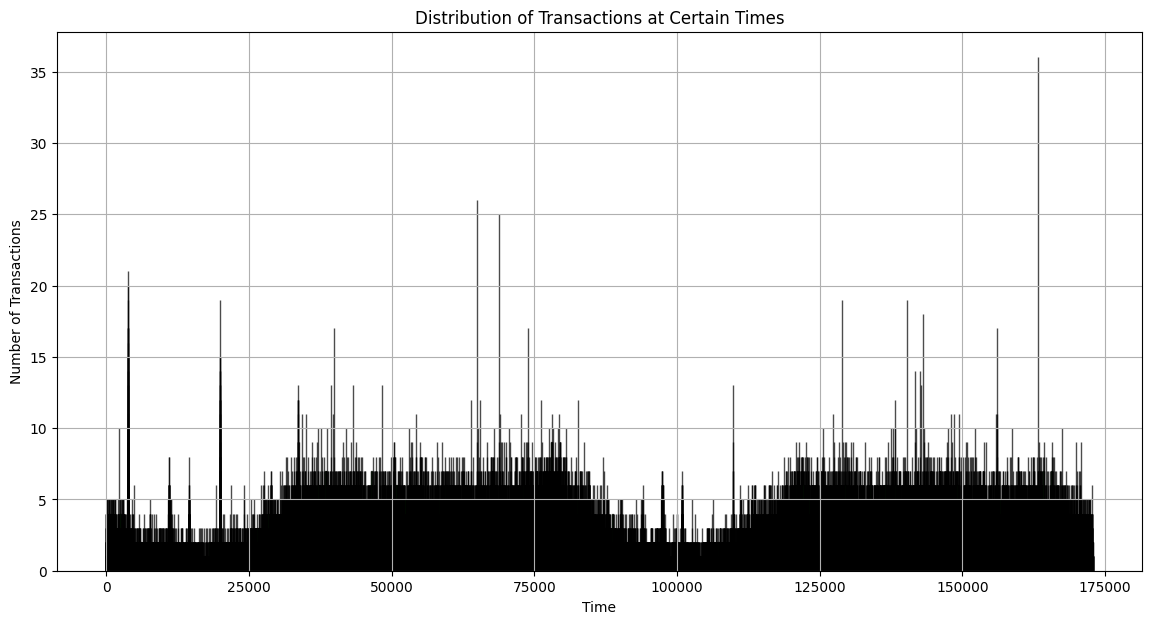

In [22]:
plt.figure(figsize=(14, 7))
plt.bar(time_order_counts.index, time_order_counts.values, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions at Certain Times')
plt.grid(True)
plt.show()

#### Standarizing Values

The Values are already standardized but I will do it again just to be sure. The new features can also be scaled the same. 

In [12]:
df = df.drop(columns=['Time']) # We don't need this much since Time Since last fraud is another way with more information

In [13]:
columns_to_standardize = df.columns.difference(['Class', 'Transaction_Order'])
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

#### PCA

This data already comes in PCA(not sure how much variability is accounted for), but a lot of qualitative data is removed for identification, so we don't have much to work with. for this reason, we will use all rows, but this is here to show that if you need to reduce components, you can decide on a number of components and reduce until you have 80-90% of variability of data explained. 

In [27]:
features = df.drop(columns=['Class'])

In [28]:
pca = PCA(n_components=26)
principal_components = pca.fit_transform(features)

In [29]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
print("Total variance explained by all components:", cumulative_explained_variance[-1])

Total variance explained by all components: 0.879965346342924


#### Handling Outliers

We are currently looking for outliers, but each individiuals variables can have outliers. we can either look at the boxplot or look at the standard deviation. Right now I will just use regular data since we are looking for outlier, and then look more into outliers to see if they impact model performance. I wouldn't want to find outlier in variable and remove a possible fraud case.

## Model Training

This goes through all the models. Since there is a class imbalance I choose methods which are classification based, but can also handle imbalanced data. Ensemble methods and clustering is good for this, but I include logistic regression too as a baseline.

In [14]:
X = df.drop(columns=['Class']) 
y = df['Class']

### Split Data into Train/Test(80/20)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to make sure same amount of fraud is in train and test

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #Cross Validation Set
smote = SMOTE(random_state=42)# for oversampling

#### Handling Inbalanced data

You can use oversample or undersampling based on if you have a small or large dataset. The thing i was a bit hesistent about was the frauds can happen close to one another and removing or generating can impact how the model sees the fraud transaction orders. I will test to see which gives better results. Since we are doing Cross validation the Inbalanced will be handled in the code where you only apply the resampling on the train set.

#### Defining model for reusability

In [61]:
def evaluate_model(model, X_train = X_train, y_train=y_train, skf=skf):
    fold_roc_auc_scores = []
    fold_pr_auc_scores = []
    fold_acc_scores = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []

    for train_idx, val_idx in skf.split(X_train, y_train):
    
        X_fold, y_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        # Apply SMOTE
        X_res, y_res = smote.fit_resample(X_fold, y_fold)

        # Train model
        model.fit(X_res, y_res)
    
        # Predict on validation set
        val_preds = model.predict(X_val)
        val_proba = model.predict_proba(X_val)[:, 1]  # For AUC if needed

        # Compute evaluation metrics
        roc_auc = roc_auc_score(y_val, val_proba)
        pr_auc = average_precision_score(y_val, val_proba)
        acc_score = accuracy_score(y_val, val_preds)
        precision = precision_score(y_val, val_preds)
        recall = recall_score(y_val, val_preds)
        f1 = f1_score(y_val, val_preds)
        conf_matrix = confusion_matrix(y_val, val_preds)

        # Store metrics for averaging
        fold_roc_auc_scores.append(roc_auc)
        fold_pr_auc_scores.append(pr_auc)
        fold_acc_scores.append(acc_score)
        fold_precision.append(precision)
        fold_recall.append(recall)
        fold_f1.append(f1)

        # Print metrics for this fold
        print(f"Fold ROC AUC: {roc_auc:.4f}")
        print(f"Fold PR AUC: {pr_auc:.4f}")
        print(f"Fold Accuracy: {acc_score:.4f}")
        print(f"Fold Precision: {precision:.4f}")
        print(f"Fold Recall: {recall:.4f}")
        print(f"Fold F1-Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}\n")
    
    # Average metrics over all folds
    print(f"Average ROC AUC: {np.mean(fold_roc_auc_scores):.4f}")
    print(f"Average PR AUC: {np.mean(fold_pr_auc_scores):.4f}")
    print(f"Average Accuracy: {np.mean(fold_acc_scores):.4f}")
    print(f"Average Precision: {np.mean(fold_precision):.4f}")
    print(f"Average Recall: {np.mean(fold_recall):.4f}")
    print(f"Average F1-Score: {np.mean(fold_f1):.4f}")

In [18]:
def plot_roc_curve(model, X_test, y_test):
    # Predict the probabilities for the positive class (1)
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [65]:
def evaluate_test(model, X_test = X_test, y_test=y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    average_precision = average_precision_score(y_test, y_proba)
    
    # Print the evaluation metrics
    print(f'Test Set Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    print(f'Test Set ROC AUC: {auc_score}')
    print(f'Test Set PR AUC: {average_precision}')

    plot_roc_curve(model, X_test, y_test)

   # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, marker='.', label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

### Classification

### KNN

In [73]:
model_knn = KNeighborsClassifier()
evaluate_model(model_knn, X_train=X_train, y_train=y_train, skf=skf)

Fold ROC AUC: 0.9480
Fold PR AUC: 0.5180
Fold Accuracy: 0.9977
Fold Precision: 0.4198
Fold Recall: 0.8718
Fold F1-Score: 0.5667
Confusion Matrix:
[[45397    94]
 [   10    68]]

Fold ROC AUC: 0.9108
Fold PR AUC: 0.5530
Fold Accuracy: 0.9974
Fold Precision: 0.3824
Fold Recall: 0.8228
Fold F1-Score: 0.5221
Confusion Matrix:
[[45385   105]
 [   14    65]]

Fold ROC AUC: 0.9109
Fold PR AUC: 0.5946
Fold Accuracy: 0.9978
Fold Precision: 0.4324
Fold Recall: 0.8101
Fold F1-Score: 0.5639
Confusion Matrix:
[[45406    84]
 [   15    64]]

Fold ROC AUC: 0.9615
Fold PR AUC: 0.6509
Fold Accuracy: 0.9977
Fold Precision: 0.4244
Fold Recall: 0.9241
Fold F1-Score: 0.5817
Confusion Matrix:
[[45391    99]
 [    6    73]]

Fold ROC AUC: 0.9362
Fold PR AUC: 0.6208
Fold Accuracy: 0.9977
Fold Precision: 0.4136
Fold Recall: 0.8481
Fold F1-Score: 0.5560
Confusion Matrix:
[[45395    95]
 [   12    67]]

Average ROC AUC: 0.9335
Average PR AUC: 0.5875
Average Accuracy: 0.9977
Average Precision: 0.4145
Average Reca

### Ensemble Methods

This goes over ensemble methods and uses hyperparameter tuning. This also goes through checking cross-validation by using strafied k fold

In [40]:
#Parameters to grid search. This is not much, but my computer can't handle much
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'scale_pos_weight': [1, 10, 25]  
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7],
        'auto_class_weights': ['Balanced', 'SqrtBalanced']  
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100], 
        'min_gain_to_split': [0.01, 0.1, 0.2],   
        'is_unbalance': [True, False]
    }
}

#### Random Forest

In [72]:
# Define GridSearchCV 
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grids['RandomForest'], scoring='f1', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_rf = grid_search.best_estimator_
print(f"Best parameters for RandomForest: {grid_search.best_params_}")

evaluate_model(best_model_rf, X_train = X_train, y_train=y_train, skf=skf)

Best parameters for RandomForest: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold ROC AUC: 0.9880
Fold PR AUC: 0.8364
Fold Accuracy: 0.9992
Fold Precision: 0.7722
Fold Recall: 0.7821
Fold F1-Score: 0.7771
Confusion Matrix:
[[45473    18]
 [   17    61]]

Fold ROC AUC: 0.9625
Fold PR AUC: 0.8057
Fold Accuracy: 0.9994
Fold Precision: 0.8571
Fold Recall: 0.7595
Fold F1-Score: 0.8054
Confusion Matrix:
[[45480    10]
 [   19    60]]

Fold ROC AUC: 0.9552
Fold PR AUC: 0.8082
Fold Accuracy: 0.9993
Fold Precision: 0.8429
Fold Recall: 0.7468
Fold F1-Score: 0.7919
Confusion Matrix:
[[45479    11]
 [   20    59]]

Fold ROC AUC: 0.9865
Fold PR AUC: 0.8730
Fold Accuracy: 0.9993
Fold Precision: 0.7527
Fold Recall: 0.8861
Fold F1-Score: 0.8140
Confusion Matrix:
[[45467    23]
 [    9    70]]

Fold ROC AUC: 0.9791
Fold PR AUC: 0.8505
Fold Accuracy: 0.9995
Fold Precision: 0.8571
Fold Recall: 0.8354
Fold F1-Score: 0.8462
Confusion Matrix:


#### XGBoost

In [71]:
# Define GridSearchCV 
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grids['XGBoost'], scoring='f1', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_xg = grid_search.best_estimator_
print(f"Best parameters for XGBoost: {grid_search.best_params_}")

evaluate_model(best_model_xg, X_train = X_train, y_train=y_train, skf=skf)

Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.9}
Fold ROC AUC: 0.9826
Fold PR AUC: 0.8221
Fold Accuracy: 0.9989
Fold Precision: 0.6337
Fold Recall: 0.8205
Fold F1-Score: 0.7151
Confusion Matrix:
[[45454    37]
 [   14    64]]

Fold ROC AUC: 0.9712
Fold PR AUC: 0.8203
Fold Accuracy: 0.9990
Fold Precision: 0.6809
Fold Recall: 0.8101
Fold F1-Score: 0.7399
Confusion Matrix:
[[45460    30]
 [   15    64]]

Fold ROC AUC: 0.9606
Fold PR AUC: 0.8240
Fold Accuracy: 0.9990
Fold Precision: 0.6667
Fold Recall: 0.8354
Fold F1-Score: 0.7416
Confusion Matrix:
[[45457    33]
 [   13    66]]

Fold ROC AUC: 0.9738
Fold PR AUC: 0.8950
Fold Accuracy: 0.9987
Fold Precision: 0.5868
Fold Recall: 0.8987
Fold F1-Score: 0.7100
Confusion Matrix:
[[45440    50]
 [    8    71]]

Fold ROC AUC: 0.9853
Fold PR AUC: 0.8551
Fold Accuracy: 0.9991
Fold Precision: 0.6907
Fold Recall: 0.8481
Fold F1-Score: 0.7614
Conf

#### LightGBM

In [68]:
# Define GridSearchCV 
grid_search = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grids['LightGBM'], scoring='f1', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_lgbm = grid_search.best_estimator_
print(f"Best parameters for LightGBM: {grid_search.best_params_}")

evaluate_model(best_model_lgbm, X_train = X_train, y_train=y_train, skf=skf)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7675
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

#### CatBoost

In [69]:
# Define GridSearchCV 
grid_search = GridSearchCV(estimator=CatBoostClassifier(silent=True), param_grid=param_grids['CatBoost'], scoring='f1', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_cat = grid_search.best_estimator_
print(f"Best parameters for CatBoost: {grid_search.best_params_}")

evaluate_model(best_model_cat, X_train = X_train, y_train=y_train, skf=skf)

Best parameters for CatBoost: {'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'iterations': 200, 'learning_rate': 0.2}
Fold ROC AUC: 0.9781
Fold PR AUC: 0.8247
Fold Accuracy: 0.9984
Fold Precision: 0.5289
Fold Recall: 0.8205
Fold F1-Score: 0.6432
Confusion Matrix:
[[45434    57]
 [   14    64]]

Fold ROC AUC: 0.9730
Fold PR AUC: 0.7909
Fold Accuracy: 0.9986
Fold Precision: 0.5810
Fold Recall: 0.7722
Fold F1-Score: 0.6630
Confusion Matrix:
[[45446    44]
 [   18    61]]

Fold ROC AUC: 0.9604
Fold PR AUC: 0.7854
Fold Accuracy: 0.9982
Fold Precision: 0.4923
Fold Recall: 0.8101
Fold F1-Score: 0.6124
Confusion Matrix:
[[45424    66]
 [   15    64]]

Fold ROC AUC: 0.9764
Fold PR AUC: 0.8549
Fold Accuracy: 0.9981
Fold Precision: 0.4730
Fold Recall: 0.8861
Fold F1-Score: 0.6167
Confusion Matrix:
[[45412    78]
 [    9    70]]

Fold ROC AUC: 0.9738
Fold PR AUC: 0.8333
Fold Accuracy: 0.9983
Fold Precision: 0.5000
Fold Recall: 0.8481
Fold F1-Score: 0.6291
Confusion Matrix:
[[45423    67]
 [   

### Logistic Regression

In [70]:
model_lr = LogisticRegression(random_state=42, max_iter=1000,tol=1e-4)
evaluate_model(model_lr, X_train = X_train, y_train=y_train, skf=skf)    

Fold ROC AUC: 0.9897
Fold PR AUC: 0.7878
Fold Accuracy: 0.9714
Fold Precision: 0.0526
Fold Recall: 0.9231
Fold F1-Score: 0.0994
Confusion Matrix:
[[44193  1298]
 [    6    72]]

Fold ROC AUC: 0.9822
Fold PR AUC: 0.7403
Fold Accuracy: 0.9749
Fold Precision: 0.0574
Fold Recall: 0.8734
Fold F1-Score: 0.1076
Confusion Matrix:
[[44356  1134]
 [   10    69]]

Fold ROC AUC: 0.9623
Fold PR AUC: 0.6798
Fold Accuracy: 0.9736
Fold Precision: 0.0546
Fold Recall: 0.8734
Fold F1-Score: 0.1028
Confusion Matrix:
[[44296  1194]
 [   10    69]]

Fold ROC AUC: 0.9931
Fold PR AUC: 0.7968
Fold Accuracy: 0.9699
Fold Precision: 0.0507
Fold Recall: 0.9241
Fold F1-Score: 0.0961
Confusion Matrix:
[[44123  1367]
 [    6    73]]

Fold ROC AUC: 0.9805
Fold PR AUC: 0.7221
Fold Accuracy: 0.9732
Fold Precision: 0.0560
Fold Recall: 0.9114
Fold F1-Score: 0.1056
Confusion Matrix:
[[44277  1213]
 [    7    72]]

Average ROC AUC: 0.9816
Average PR AUC: 0.7454
Average Accuracy: 0.9726
Average Precision: 0.0543
Average Reca

## Comparision of Models

Comparing all the models, we want to look mainly at the f1 score and the AUC applied on the fraud caases. AUC doesn't work well on imbalanced data, but we did use oversampling of the minority to help cancel this out a bit. The f1 score and precision recall gives better comparision for the fraud cases.

#### KNN:

Average ROC AUC: 0.9335

Average PR AUC: 0.5875

Average Accuracy: 0.9977

Average Precision: 0.4145

Average Recall: 0.8554

Average F1-Score: 0.5581

#### Random Forest:

Average ROC AUC: 0.9743

Average PR AUC: 0.8347

Average Accuracy: 0.9993

Average Precision: 0.8164

Average Recall: 0.8020

Average F1-Score: 0.8069

#### XGBoost:

Average ROC AUC: 0.9747

Average PR AUC: 0.8433

Average Accuracy: 0.9989

Average Precision: 0.6517

Average Recall: 0.8426

Average F1-Score: 0.7336

#### LightGBM:

Average ROC AUC: 0.9758

Average PR AUC: 0.7508

Average Accuracy: 0.9942

Average Precision: 0.2064

Average Recall: 0.8351

Average F1-Score: 0.3307

#### CatBoost:

Average ROC AUC: 0.9724

Average PR AUC: 0.8178

Average Accuracy: 0.9983

Average Precision: 0.5150

Average Recall: 0.8274

Average F1-Score: 0.6329

#### Logistic Regression:

Average ROC AUC: 0.9816

Average PR AUC: 0.7454

Average Accuracy: 0.9726

Average Precision: 0.0543

Average Recall: 0.9011

Average F1-Score: 0.1023
11
Average F1-Score: 0.1023



Overall, Random Forest did better than all the models with XGBoost coming in second place. This might be due to parameter tuning because I did not have the ability to test many parameters as it took around a day to run all the models on my laptop. This was also because I was changing parameters and adding code, rerunning the parameters multiple times on different methods to make sure I get the best model possible. Random Forest had the best PR AUC and also the best F1 which is the best criterion when working with imbalanced data.

## Evaluate on Test

In [83]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
best_model = best_model_rf.fit(X_train_smote, y_train_smote)

Test Set Accuracy: 0.9992802219023208
Confusion Matrix:
[[56840    24]
 [   17    81]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.83      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Test Set ROC AUC: 0.967922838451644
Test Set PR AUC: 0.8620882298145554


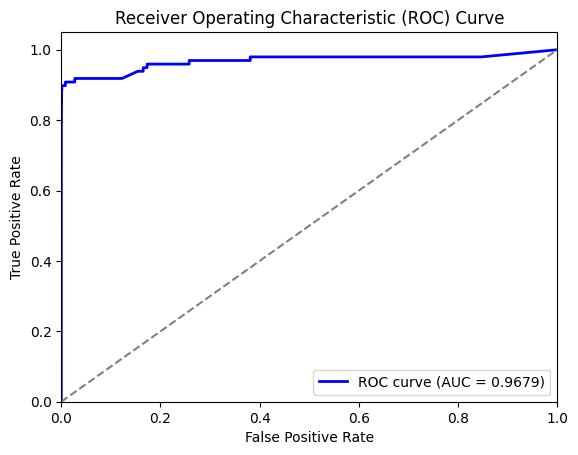

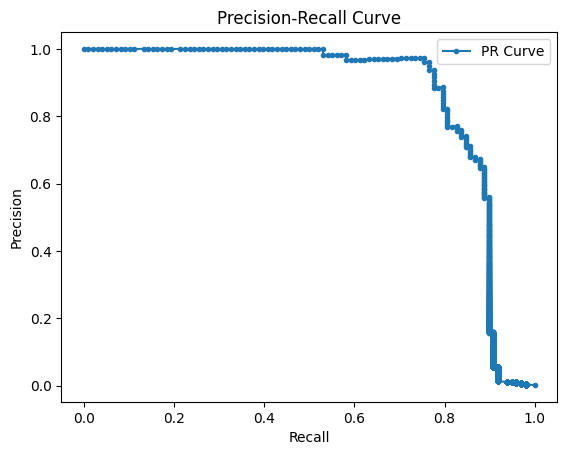

In [84]:
evaluate_test(best_model, X_test = X_test, y_test=y_test)

We can see that It performed about as well on the test set as well as on the training set. This shows that we didn't overfit. We were missing some features that were left out for security reasons that might be able to help figure out the fraud cases better, but overall this did well. The Random Forest got 0.86 Precision Recall AUC which is a good model. This also has good precision and recall and worked well on imbalanced data.

While f1 score and precision recall might be best, it might be useful to pick models with highest precision on fraud cases with some cases that are borderline even if they are not a fraud moving to fraud cases. This could make it so all fraud cases can be caught with more false positives, but it saves possible frauds. Most of the models I made got around same false negatives, which should be looked into more to improve algorithm

## Conclusion

This project helped me learn a lot on how to deal with imbalanced data. I was famiiliar with all the algorithms, but I learned about new parameters and resampling techniques to deal with imbalanced data. I also learned more about the Precision-Recall tradeoff. In this case I think getting more prevision and getting lower recall works better since you want to make sure frauds are captured. The recall must still be acceptable though. The dataset did not have catergorical features, but I think having things like location of the transaction and checking it with the users usual transaction can give a better understanding. The features I engineered were the ones I thought off given that we only have few columns labeled with PCA and everything already applied.